<div style="float: block; text-align: center; line-height: 1.7em">
    <span style="font-size: 2em; font-weight: bold"> Fatigue-Sleepiness in Irregular Workloads for Pilots </span><br>
    <span style="font-size: 1.5em; font-weight: bold"> Statistical Modelling - Perceived Fatigue </span><br>
</div>

---

### Table of contents

##### [1. Loading required libraries](#section1)
 
##### [2. Loading Data](#section2)

##### [3. Preparing Data to Regression Analysis](#section3)

###### [3.1. Counting and Removing NaN rows](#section31)

##### [4. Regression Analysis](#section4)

###### [4.1. Counting and Removing NaN rows](#section41)

###### [4.2. First Iteration](#section42)

###### [4.3. Second Iteration](#section43)

###### [4.4. Third Iteration](#section44)

###### [4.5. Fourth Iteration](#section45)


---

# 1. Loading required libraries and packages <a name="section1"></a>

In [2]:
import os as os                                      # system library
import pandas as pd                                  # library to handle databases
import numpy as np                                   # library to handle arrays and matrices
import matplotlib.pyplot as plt                      # graphical package
import seaborn as sns                                # beautification graphical package

from pymer4.models import Lmer                       # Package for statistical modelling

---

# 2. Loading Data <a name="section2"></a>

## 2.1. Reading database from file

In [4]:
file = os.path.join('data','processed_to_regression.csv')

df = pd.read_csv(file)
df.head(3)

,Id,Record_time_stamp,kss,sps,kssd,spsd,time_fill_kss_sps,duty_moment,duty_type_2,duty_type_prev_es,...,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,nap_number,select
0,P01,07/12/2021 12:21,5,4.0,0,0,AFT,start,others,0,...,univ,married,60,49,13,9,14,INT,0,1
1,P01,07/12/2021 19:57,5,5.0,0,0,EVE,middle,others,0,...,univ,married,60,49,13,9,14,INT,0,1
2,P01,08/12/2021 00:15,7,6.0,1,1,NI,end,others,0,...,univ,married,60,49,13,9,14,INT,0,1


## 2.2. Selecting only working days

In [6]:
working_df = df[ (df['duty_moment'].isin(['start','middle','end'])) & (df['select']==1) ]
working_df.head(3)

,Id,Record_time_stamp,kss,sps,kssd,spsd,time_fill_kss_sps,duty_moment,duty_type_2,duty_type_prev_es,...,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,nap_number,select
0,P01,07/12/2021 12:21,5,4.0,0,0,AFT,start,others,0,...,univ,married,60,49,13,9,14,INT,0,1
1,P01,07/12/2021 19:57,5,5.0,0,0,EVE,middle,others,0,...,univ,married,60,49,13,9,14,INT,0,1
2,P01,08/12/2021 00:15,7,6.0,1,1,NI,end,others,0,...,univ,married,60,49,13,9,14,INT,0,1


---

# 3. Preparing Data to Regression Analysis <a name="section3"></a>

Before run regression analysis on data, it is advisable to apply some transformations on some data columns like, rescalling, log transformations, standardizations and etc, and possibly bucketization of categorical features.

In previous notebooks (EDA.ipynb) some transformations were applied in order to perform exploration in data.

## 3.1. Counting and removing nan rows <a name="section31"></a>

### 3.1.1. Function to display tables side by side

In [8]:
from IPython.display import display, HTML                       # html library

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").format(precision=2)\
                          .set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

### 3.1.2. Getting NaN values number per column

In [10]:
wsm = working_df.isna().sum()
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),
                      pd.DataFrame(wsm[18:24]),pd.DataFrame(wsm[24:])],
                    ['(a)','(b)','(c)','(d)','(e)'])

,0
Id,0
Record_time_stamp,0
kss,0
sps,1
kssd,0
spsd,0
,0
time_fill_kss_sps,0
duty_moment,0
duty_type_2,0


As we can see few values of NaN is present in our data set, once we have more than 1k rows, we can remove these rows without greater impacts in forward analysis, without the need for imputation or other artificial data-filling methodology.

### 3.1.3. Removing NaN rows

In [12]:
working_df = working_df.dropna()

wsm = working_df.isna().sum()
print(''); print('')
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),
                      pd.DataFrame(wsm[18:24]),pd.DataFrame(wsm[24:])],
                    ['(a)','(b)','(c)','(d)','(e)'])
print(''); print('')

,0
Id,0
Record_time_stamp,0
kss,0
sps,0
kssd,0
spsd,0
,0
time_fill_kss_sps,0
duty_moment,0
duty_type_2,0


### 3.1.4. Re-scaling some variables

Before apply logistic regression it is advisable to re-scale continuous variables in order avoid possible bias 

In [14]:
working_df['flight_hours'] = working_df['Flight_hours'].copy()/1000
working_df['age'] = working_df['Age'].copy()
working_df['time_displacement'] = working_df['Time_displacement'].copy()/60

In [16]:
working_df[['Age','flight_hours','time_displacement','time_awake','duty_length','sleep_duration','Num_Sons']].describe().round(0)

,Age,flight_hours,time_displacement,time_awake,duty_length,sleep_duration,Num_Sons
count,1014.0,1014.0,1014.0,1014.0,1014.0,1014.0,1014.0
mean,39.0,8.0,2.0,4.0,7.0,7.0,1.0
std,10.0,6.0,2.0,4.0,2.0,2.0,1.0
min,25.0,2.0,0.0,0.0,2.0,2.0,0.0
25%,32.0,4.0,1.0,2.0,6.0,6.0,0.0
50%,37.0,6.0,1.0,2.0,7.0,7.0,1.0
75%,47.0,11.0,4.0,5.0,9.0,8.0,2.0
max,66.0,29.0,7.0,17.0,12.0,12.0,2.0


A summary of the continuous variables is shown above (the numbers were rounded to the nearest integer). We will apply standardization, using the rounded standard deviation and mean, in order to easily interpret the result in terms of odds ratio.

In [18]:
working_df['age'] = working_df['Age'].copy().apply(lambda x: (x-39)/10)
working_df['flight_hours'] = working_df['flight_hours'].copy().apply(lambda x: (x-8)/6)
working_df['time_displacement'] = working_df['time_displacement'].copy().apply(lambda x: (x-2)/2)
working_df['time_awake'] = working_df['time_awake'].copy().apply(lambda x: (x-4)/4)
working_df['duty_length'] = working_df['duty_length'].copy().apply(lambda x: (x-7)/2)
working_df['sleep_duration'] = working_df['sleep_duration'].copy().apply(lambda x: (x-7)/2)

working_df[['age','flight_hours','time_displacement','time_awake','duty_length','sleep_duration']].describe().round(0)

,age,flight_hours,time_displacement,time_awake,duty_length,sleep_duration
count,1014.0,1014.0,1014.0,1014.0,1014.0,1014.0
mean,0.0,-0.0,-0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.0,-1.0,-1.0,-1.0,-3.0,-2.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-0.0
50%,-0.0,-0.0,-0.0,-0.0,0.0,0.0
75%,1.0,0.0,1.0,0.0,1.0,1.0
max,3.0,4.0,2.0,3.0,2.0,3.0


Each of these variables can be iterpreted in terms of:

* Age - each 10 years
* flight hours - each 6k hours
* time displacement - each 2 hours
* time awake - each 4 hours
* duty length - each 2 hours
* sleep duration - each 2 hours

## 3.2. Adaptations in time the participant filled kss and sps scales

Following the Exploratory Data Analysis, for time the participant fill kss and sps scales, it was seen that only for categories EM and NI, we see sharp differences in frequency of severe/excessive fatigue/sleepiness. So, following the analysis, we will recategorize the variable time the participant fill kss and sps scales into the following:

| New category | Previous category | Long name |
| --- | --- | --- |
| EM | EM | Early-Morning (05:00 - 06:59) |
| Business | MOR, AFT, EVE | Business time (07:00 - 23:59) |
| NI | NI | Night (00:00 - 04:59) |

In [20]:
working_df['time_fill_kss_sps_2'] = working_df.loc[:,'time_fill_kss_sps'].copy().apply(lambda x: 'business' if x in['AFT','MOR','EVE'] else x)

**Now the data is ready for analysis!**

---

# 4. Preliminary Regression Analysis <a name="section4"></a>

Given the experimental design discussed in [Feature_Engineering.ipynb](Feature_Engineering.ipynb),  we choose a mixed logistic model or multilevel logistic model given by:

<p style="text-align: center;"> $g(x_{ij},\beta_{0i},\beta_1, \beta_s) = \beta_{0i}+\beta_{1i}x_1 + x_{ij}^T\beta_s$  (level 1) </p>
<p style="text-align: center;"> $\beta_{0i} = \beta_0 + \alpha_i$  (level 2, random intercept) </p>
<p style="text-align: center;"> $\beta_{1i} = \beta_1 + \tau_i$  (level 2, random slope) </p>

where $\alpha_i \sim N(0,\sigma_\alpha^2)$ and $\tau_i \sim N(0,\sigma_\tau^2)$ with $\alpha_i \perp \tau_i$.

In our setting, the random slope is due to time the participants filled the scales and the random intercept is due to participant cluster and time the participant filled the scales.

## 4.0. Function to codify formula in pymer standards <a name="section41"></a>

In [152]:
def get_formula(covariates, target, prnt = False):
    formula = f'{target}~'
    for cvt in covariates:
        formula += cvt+'+'
    formula = formula[:-1]
    if prnt:
        print(f'formula:\n{formula}')
    return formula

## 4.1. First Iteration <a name="section42"></a>

In [ ]:
# Pymer default put the first category in alphabetical order as reference. So, we want that the start of duty be the reference
working_df['duty_moment_2'] = working_df.loc[:,'duty_moment'].copy().apply(lambda x: 'astart' if x in ['start'] else x)

# We need to transform num of sons in factor format
working_df['Num_Sons_2'] = working_df.loc[:,'Num_Sons'].copy().apply(lambda x: '0' if x==0 else str(x))

In [260]:
%%time

covariates = ['duty_moment_2','time_fill_kss_sps_2',
              'duty_length','sleep_duration','time_awake','Position','Num_Sons_2','education',
              'marital_status','time_displacement','flight_hours','Classification','Sex','age']

formula = get_formula(covariates, 'spsd', prnt=False)

ff = formula + '+(1+1|Id)'

model_LME = Lmer(ff, data = working_df, family = 'binomial')
mdf = model_LME.fit()

print(mdf)

Model failed to converge with max|grad| = 0.0535105 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: spsd~duty_moment_2+time_fill_kss_sps_2+duty_length+sleep_duration+time_awake+Position+Num_Sons_2+education+marital_status+time_displacement+flight_hours+Classification+Sex+age+(1+1|Id)

Family: binomial	 Inference: parametric

Number of observations: 1014	 Groups: {'Id': 43.0}

Log-likelihood: -188.367 	 AIC: 416.734

Random effects:

           Name    Var    Std
Id  (Intercept)  0.369  0.607

No random effect correlations specified

Fixed effects:

                       Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  \
(Intercept)              -8.963 -11.500   -6.425  1.295   0.000      0.000   
duty_moment_2end          4.389   2.929    5.850  0.745  80.577     18.706   
duty_moment_2middle       2.024   0.466    3.583  0.795   7.572      1.593   
time_fill_kss_sps_2EM     1.307   0.336    2.278  0.495   3.695      1.399   
time_fi

C:\Users\jlpsc\.conda\envs\pymer4\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Using the Wald test (P>|z|) at level of 5%, we need to review the following variables:

In [262]:
fix_efc = pd.DataFrame({ 'pval': [v[-2] for v in mdf.values], 'sig': mdf.Sig } )
display_side_by_side([fix_efc[fix_efc.pval > 0.05].head(100)[0:5], fix_efc[fix_efc.pval > 0.05].head(100)[5:] ],
                     ['(a)','(b)'])

,pval,sig
sleep_duration,0.07,.
PositionCOPIL,0.23,
Num_Sons_21,0.06,.
educationuniv,0.54,
time_displacement,0.33,
,pval,sig
flight_hours,0.72,
ClassificationVES,0.22,
SexMALE,0.18,
age,0.13,


We will retain and modify the following covariates:

* For Classification, we will merge category VES (Vespertine) with INT (intermediary) into "VES+INT";

* For Number of Sons, we will merge the category "1" with "0" into "0-1" son;

* For time fill kss and sps scales, we will retain this variables as it is by now.

* Sleep duration

## 4.2. Second Iteration

In [265]:
# Recategorizing Classification
working_df['Classification_2'] = working_df.loc[:,'Classification'].copy().apply(lambda x: 'INT+VES' if x in ['VES','INT'] else x)

# Recategorizing Number of Sons
working_df['Num_Sons_3'] = working_df.loc[:,'Num_Sons'].copy().apply(lambda x: '0-1' if x in [0,1] else str(x))

In [267]:
%%time

covariates = ['duty_moment_2','time_fill_kss_sps_2','duty_type_2',
              'duty_length','time_awake','Num_Sons_3',
              'marital_status','Classification_2','sleep_duration']

formula2 = get_formula(covariates, 'spsd', prnt=False)

ff2 = formula2 + '+(1+1|Id)'

model_LME2 = Lmer(ff2, data = working_df, family = 'binomial')
mdf2 = model_LME2.fit()

print(mdf2)

Model failed to converge with max|grad| = 0.0084598 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: spsd~duty_moment_2+time_fill_kss_sps_2+duty_type_2+duty_length+time_awake+Num_Sons_3+marital_status+Classification_2+sleep_duration+(1+1|Id)

Family: binomial	 Inference: parametric

Number of observations: 1014	 Groups: {'Id': 43.0}

Log-likelihood: -193.057 	 AIC: 412.115

Random effects:

           Name   Var    Std
Id  (Intercept)  0.87  0.933

No random effect correlations specified

Fixed effects:

                       Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  \
(Intercept)              -6.805  -8.563   -5.047  0.897   0.001      0.000   
duty_moment_2end          4.403   2.933    5.873  0.750  81.706     18.785   
duty_moment_2middle       1.947   0.379    3.515  0.800   7.007      1.460   
time_fill_kss_sps_2EM     0.960  -0.060    1.979  0.520   2.611      0.942   
time_fill_kss_sps_2NI     0.992   0.149    1.834  0.4

C:\Users\jlpsc\.conda\envs\pymer4\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Using the Wald test (P>|z|) at level of 5%, we need to review the following variables:

In [269]:
fix_efc = pd.DataFrame({ 'pval': [v[-2] for v in mdf2.values], 'sig': mdf2.Sig } )
fix_efc[fix_efc.pval > 0.05].head(100)

,pval,sig
time_fill_kss_sps_2EM,0.065,.
sleep_duration,0.122,


As we can see the variables time the participant filled kss and sps scales and sleep duration present high p-value, indicating non statistical significant value.

To address this issue we will merge EM into business category becoming this variable just an indicator of Night time, and sleep duration will be removed.

## 4.3. Third Iteration

In [282]:
%%time
#duty_type_2
covariates = ['duty_moment_2','time_fill_kss_sps_2',
              'duty_length','time_awake','Num_Sons_3',
              'marital_status','Classification_2']

formula3 = get_formula(covariates, 'spsd', prnt=False)

ff3 = formula3 + '+(1+1|Id)'

model_LME3 = Lmer(ff3, data = working_df, family = 'binomial')
mdf3 = model_LME3.fit()

print(mdf3)

Model failed to converge with max|grad| = 0.0351464 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: spsd~duty_moment_2+time_fill_kss_sps_2+duty_length+time_awake+Num_Sons_3+marital_status+Classification_2+(1+1|Id)

Family: binomial	 Inference: parametric

Number of observations: 1014	 Groups: {'Id': 43.0}

Log-likelihood: -196.972 	 AIC: 415.944

Random effects:

           Name    Var    Std
Id  (Intercept)  0.763  0.873

No random effect correlations specified

Fixed effects:

                       Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  \
(Intercept)              -7.051  -8.751   -5.351  0.867   0.001      0.000   
duty_moment_2end          4.391   2.910    5.871  0.755  80.689     18.354   
duty_moment_2middle       2.052   0.473    3.631  0.806   7.783      1.605   
time_fill_kss_sps_2EM     1.270   0.296    2.244  0.497   3.560      1.344   
time_fill_kss_sps_2NI     1.226   0.425    2.028  0.409   3.408      1.529   


C:\Users\jlpsc\.conda\envs\pymer4\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


* As we can see all covariates now, seem to be statistcally significant at the level of 0.05.

### 4.3.1. Performance Analysis - Receiver Operator Curve (ROC)

In [309]:
# Getting predictions from training set, evaluated by the model
df_res = pd.DataFrame({'y_that':list(model_LME3.fits),'y':working_df.spsd})

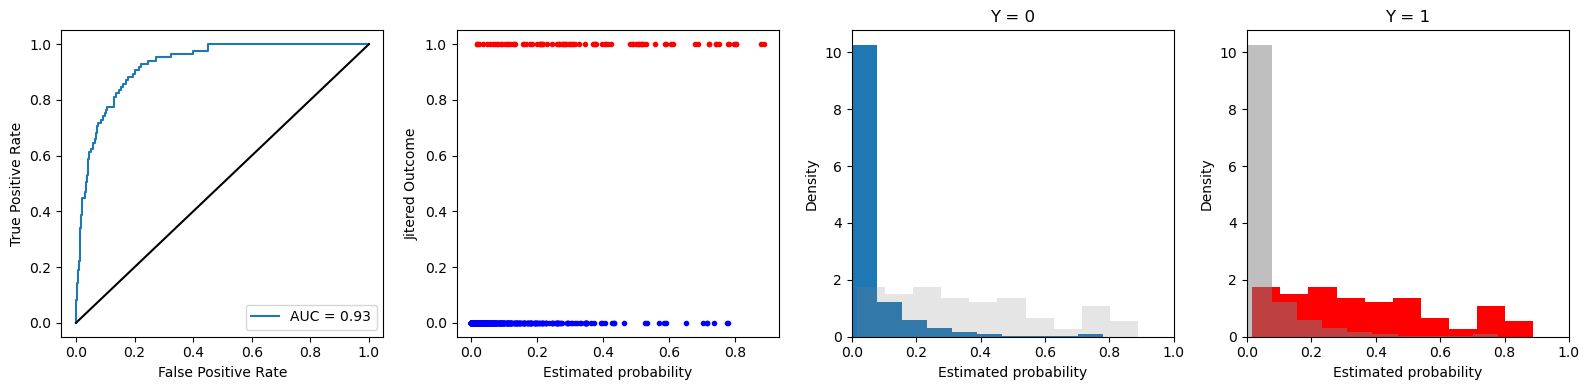

In [343]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,accuracy_score, confusion_matrix, auc

# Computing ROC curve
fpr, tpr, _ = roc_curve(df_res['y'], df_res['y_that']-min(df_res['y_that']))
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1,4, figsize = (16,4))

ax[0].plot(fpr, tpr, label=f'AUC = {str(round(roc_auc, 2))}')
ax[0].plot(np.linspace(0,1,10), np.linspace(0,1,10), color = 'black')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')

ax[1].plot(df_res.y_that[df_res.y == 0], df_res.y[df_res.y == 0],'.' ,color = 'blue')
ax[1].plot(df_res.y_that[df_res.y == 1], df_res.y[df_res.y == 1],'.',color = 'red')
ax[1].set_xlabel('Estimated probability')
ax[1].set_ylabel('Jitered Outcome')

ax[2].hist(df_res.y_that[df_res.y == 0], density = True)
ax[2].hist(df_res.y_that[df_res.y == 1], density = True, color = 'gray', alpha=0.2)
ax[2].set_xlabel('Estimated probability')
ax[2].set_ylabel('Density')
ax[2].set_title('Y = 0')
ax[2].set_xlim(0,1)

ax[3].hist(df_res.y_that[df_res.y == 1], density = True, color = 'red')
ax[3].hist(df_res.y_that[df_res.y == 0], density = True, color = 'gray', alpha=0.5)
ax[3].set_xlabel('Estimated probability')
ax[3].set_ylabel('Density')
ax[3].set_title('Y = 1')
ax[3].set_xlim(0,1)

plt.tight_layout()
plt.show()

* As we can see, the ROC curve presents a nice aspect and the metric, Area Under the Curve (AUC) presents a high value, that following [Hosmer and Lemeshow, 2013](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118548387), we can consider this model as an outstanding discriminator.

* The density plots as for Y=0 well as for Y=1, show a reasonable separation in terms of occurrence of non severe and severe perception of fatigue, where perception of non-severe cases presents higher density bellow 0.02 and perception of severe cases are well distributed along all the probability axis.

### 4.3.2. Confusion Matrix

In [375]:
df_res['y_that_bin'] = df_res['y_that'].apply(lambda x: 1 if x>= 0.26 else 0)
tn, fp, fn, tp = confusion_matrix(df_res['y'], df_res['y_that_bin']).ravel()
df_tmp = pd.DataFrame({'pred 1':[tp,fp], 'pred 0':[fn,tn], 'ind':['obs 1','obs 0']}).set_index('ind')
df_tmp.head()

,pred 1,pred 0
ind,,
obs 1,52,33
obs 0,47,882


### 4.3.3. Regression Coefficients Interpretation

In [10]:
df_coefs = model_LME3.coefs[['OR', 'OR_2.5_ci', 'OR_97.5_ci']].iloc[1:]
df_coefs.iloc[-2] = 1/df_coefs.iloc[-2]

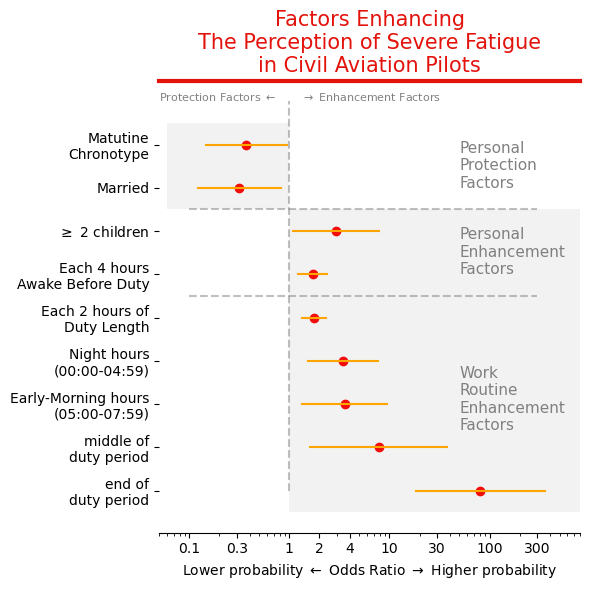

In [40]:
fig, ax = plt.subplots(1,1, figsize = (6,6))

for i in range(len(df_coefs)):
    ax.plot( [df_coefs['OR_2.5_ci'].iloc[i],df_coefs['OR_97.5_ci'].iloc[i]], [i,i], color = 'orange')

ax.scatter(df_coefs['OR'], list(range(len(df_coefs))), color = 'red')

ax.plot([1,1],[0,len(df_coefs)], '--', color = 'gray', alpha = 0.5)
ax.plot([0.1,300], [4.5, 4.5], '--', color = 'gray', alpha = 0.5)
ax.plot([0.1,300], [6.5, 6.5], '--', color = 'gray', alpha = 0.5)

ax.set_xscale('log')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('#E3120B')
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

labs = ['end of\nduty period','middle of\nduty period','Early-Morning hours\n(05:00-07:59)','Night hours\n(00:00-04:59)',
        'Each 2 hours of\nDuty Length',
        'Each 4 hours\nAwake Before Duty', r'$\geq$ 2 children', 'Married', 'Matutine\nChronotype']
ax.set_yticks(list(range(len(df_coefs))), labels = labs)
ax.set_xticks([0.1, 0.3, 1, 2, 4, 10, 30, 100, 300], labels = [0.1, 0.3, 1, 2, 4, 10, 30, 100, 300])
ax.set_xlim([0.05, 800])

ax.set_xlabel(r"Lower probability $\leftarrow$ Odds Ratio $\rightarrow$ Higher probability")
ax.set_title('Factors Enhancing\nThe Perception of Severe Fatigue\nin Civil Aviation Pilots',
             color = '#E3120B', size = 15)

ax.text(0.05,9,r'Protection Factors $\leftarrow$',color = 'gray', size = 8 )
ax.text(1.3,9,   r'$\rightarrow$ Enhancement Factors',color = 'gray', size = 8 )
ax.text(50,1.4, 'Work\nRoutine\nEnhancement\nFactors', color = 'gray', size = 11)
ax.text(50,5, 'Personal\nEnhancement\nFactors', color = 'gray', size = 11)
ax.text(50,7, 'Personal\nProtection\nFactors', color = 'gray', size = 11)

ax.fill([1,800,800,1],[-0.5,-0.5,4.5,4.5], color = 'gray', alpha = 0.1, edgecolor = None)
ax.fill([1,800,800,1],[6.5,6.5,4.5,4.5], color = 'gray', alpha = 0.1, edgecolor = None)
ax.fill([1,0.06,0.06,1],[6.5,6.5,8.5,8.5], color = 'gray', alpha = 0.1 , edgecolor = None)
plt.tight_layout()
plt.show()
fig.savefig('figures/fatigue_coeffs_odds.png')

In figure above the model's coefficients represented as odds ratio is shown. 

We can see that for all variables retained the 95% confidence bounds or error bars do not intercept the line 1, representing no significant odds ratio, confirming our previous analysis graphically. 

In [582]:
df_coefs.head(100)

,OR,OR_2.5_ci,OR_97.5_ci
duty_moment_2end,80.689433,18.354473,354.724678
duty_moment_2middle,7.783348,1.604847,37.748458
time_fill_kss_sps_2EM,3.559983,1.344164,9.428523
time_fill_kss_sps_2NI,3.408126,1.529176,7.595804
duty_length,1.767628,1.341291,2.329479
time_awake,1.705251,1.220394,2.382741
Num_Sons_32,2.917991,1.088785,7.820346
marital_statussingle,0.315012,0.815830,0.121634
Classification_2MAT,0.370510,0.145613,0.942758


Table above shows the values of regression coefficients as odds ratio, so we can interpret it as:

* At the end of duty, the odds of perception of severe fatigue is 80.7($[18.3, 354.7]$) times that at the start of duty period, keeping all other covariates constant;

* At the middle of duty, the odds of perception of severe fatigue is 7.8 ($[1.6, 77.7]$) times that at the start of duty period, keeping all other covariates constant.

* At the Early-Moring hours (05:00-07:59) the odds of perception of severe fatigue is 3.6 ($[1.3,9.4]$) times that at business hours (08:00 - 11:59), keeping all other covariates constant;

* At the Night hours (00:00-04:59) the odds of perception of severe fatigue is 3.5 ($[1.5,7.6]$) times that at business hours (08:00 - 11:59), keeping all other covariates constant;

* For each 2 hours of duty length, the odds of perception of severe fatigue rises by 76% ($OR = 1.76 [1.34, 2.32]$) compared to any baseline, keeping all other covariates constant;

* For each 4 hours awake before the duty, the odds of perception of severe fatigue rises by 71% ($OR = 1.71 [1.22, 2.38]$) compared to any baseline, keeping all other covariates constant;

* For participants who have two or more children, the odds of perception of severe fatigue is 2.91 ($[1.08, 7.82]$) times that for participants who have one or none child.

* Married and stable union participants have 69% ($OR = 0.31 [0.12, 0.81]$) less odds of perception of severe fatigue than bachelors participants.

* Matutines chronotype participants have 63% ($OR = 0.37 [0.14, 0.94]$) less odds of perception of severe fatigue than Intermediaries or Vespertines chronotypes.

### 4.3.4. Hosmer-Lemeshow test

Another test for goodness of fit is the Hosmer-Lemeshow statistics, that compares the deciles of the binary classification statistics, the Hosmer-Lemeshow statistics H is given by:

$$ H = \sum^{G}_{g = 1}\left(\frac{(O_{1g}-E_{1g})^2}{E_{1g}}+\frac{(O_{0g}-E_{0g})^2}{E_{0g}} \right) $$

where

$$ H \sim \chi^2_{G-2} $$

and G = 10, O represent the deciles of observations and E the deciles of model predictions. We will test the model under the null hypothesis that the observed and expected proportions are the same across all observations.

In [657]:
from scipy.stats import chi2

df_res['decile'] = pd.qcut(df_res['y_that'],10)

# Observed in all deciles
obsevents_1 = df_res['y'].groupby(df_res.decile, observed=True).sum()
obsevents_0 = df_res['y'].groupby(df_res.decile, observed=True).count() - obsevents_1

# Expected events
expevents_1 = (df_res['y_that']).groupby(df_res.decile, observed=True).sum()
expevents_0 = (df_res['y_that']).groupby(df_res.decile, observed=True).count() - expevents_1

# test statistics
H = (((obsevents_0 - expevents_0)**2)/(expevents_0)).sum() + (((obsevents_1 - expevents_1)**2)/(expevents_1)).sum()

# P-valor
pvalue = 1 - chi2.cdf(H , 10-2)

print('---------------------------------------')
print(f'H: {round(H,2)}; P-value: {round(pvalue,3)}')
print('---------------------------------------')

---------------------------------------
H: 4.95; P-value: 0.763
---------------------------------------


* The Hosmer and Lemeshow statistics presents a high p-values, indicating that we cannot reject the null hypothesis that the expected and observed proportions are the same across all deciles. So, we can conclude that the model is suitable to represent the data.

### 4.3.5. Variability among cluster or Due to Differences among Participants

The variability due to clusters or due to participants differences, can be assessed through the Median Odds Ratio (MOR). Following [Hosmer and Lemeshow, (2013)](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118548387) seminal book the MOR is given by:

$$\hat{MOR} = exp\left(z_{0.75}\sqrt[]{2 \hat{\sigma}^{2}}\right)$$

wherein $z_{0.75}$ is the upper quartile of the standardized normal distribution, and $\sigma^{2}$ is the intra-cluster variance. 

In [663]:
mor = np.exp(0.6745*np.sqrt(2*0.76))    # See model's output
print('------------------------------')
print(f'MOR: {mor}')
print('------------------------------')

------------------------------
MOR: 2.2969437822872516
------------------------------


* For two randomly chosen individuals with the same values of covariates, the more prone individual have 130% (MOR = 2.30) more odds to perceive severe fatigue than the less prone individual in all such pairs.

---

## 5. Saving the Parsimonious model

In [674]:
from pymer4.io import save_model

file_path = "data/models/fatigue_model.joblib"
save_model(model_LME3, file_path)

In [4]:
# from pymer4.io import load_model

# file_path = "data/models/fatigue_model.joblib"
# model_LME3 = load_model(file_path)

# model_LME3

pymer4.models.Lmer(fitted = True, formula = spsd~duty_moment_2+time_fill_kss_sps_2+duty_length+time_awake+Num_Sons_3+marital_status+Classification_2+(1+1|Id), family = binomial)

---